# Introdução

Dado o cenário de ano eleitoral no Brasil, este trabalho procura entender de maneira simplificada o contexto atual das eleições. Utilizaremos dados obtidos no Twitter, rede social em que os candidatos e candidatas geralmente propagam mensagens com suas ideias e propostas. Lá também é possível encontrar a manifestação dos sentimentos dos eleitores através de suas opiniões sobre os candidatos, sejam elas contra ou a favor.

Os dados foram coletados diretamente da API do Twitter, e inclui 100 tweets recentes de cada um dos três principais candidatos - de acordo com as pesquisas eleitorais -, assim como diversas respostas (replies) para cada um dos tweets de cada candidato.

Procuramos responder alguns questionamentos:
- Quais os principais tópicos que estão sendo abordados pelos candidatos?
- Quão similar é o discurso entre os candidatos?
- Qual o sentimento dos eleitores sobre cada candidato?

Com as repostas a estas perguntas, acreditamos que seja possível visualizar um pouco melhor o cenário das eleições para presidência do Brasil, que em breve serão iniciadas.

Além disso, é importante mencionar que os resultados apresentados por este notebook podem variar entre diferentes execuções. Do mesmo modo, os exemplos apresentados no vídeo do projeto podem ser distintos dos que aparecem neste notebook e em suas futuras execuções.

In [23]:
import re
import pandas as pd
import json
import numpy as np
import seaborn as sns
import nltk
from bertopic import BERTopic

# Extração de Dados

In [24]:
def df_tweets_candidatos(json_filename):
    df = pd.read_json(json_filename).drop(columns = ['replies'])
    return df


def df_tweets_respostas(json_filename):
    df = pd.read_json(json_filename).dropna().reset_index()[['replies']]
    ds = []
    for replies in df['replies'].to_list():
        for reply in replies:
            ds.append(reply)

    reply_df = pd.DataFrame (ds).drop(columns = ['attachments'])
    return reply_df

def df_tweets_cadidatos_respostas(json_filename):
    df_tweets_cand = df_tweets_candidatos(json_filename)
    df_tweets_reps = df_tweets_respostas(json_filename)

    return (df_tweets_cand, df_tweets_reps)

# Pré-Processamento

In [25]:
tweets = df_tweets_candidatos('./datasets/dataset.json')


# Adicionar nomes dos candidatos no dataframe
for index, row in tweets.iterrows():
    candidato = ''
    if row.author_id == 2670726740:
      candidato = 'lula'
    elif row.author_id == 128372940:
      candidato = 'bolsonaro'
    elif row.author_id == 33374761:
      candidato = 'ciro'
    else:
      candidato = 'n/d'
    tweets.at[index, 'candidato'] = candidato

print(f'Número de tweets: {len(tweets)}\n')
print(tweets.head())

Número de tweets: 300

    author_id      conversation_id                created_at  \
0  2670726740  1560319888643719168 2022-08-18 17:37:05+00:00   
1  2670726740  1560299315905515520 2022-08-18 16:15:20+00:00   
2  2670726740  1560285152282034176 2022-08-18 15:19:03+00:00   
3  2670726740  1560266077329694720 2022-08-18 14:03:15+00:00   
4  2670726740  1560248955753095168 2022-08-18 12:55:13+00:00   

                                                text                   id  \
0  As pessoas pensam que o sucesso dos nossos gov...  1560319888643719168   
1  Já em Belo Horizonte para o primeiro comício d...  1560299315905515520   
2  Ontem Lula recebeu a visita de representantes ...  1560285152282034176   
3  RT @verdadenarede: Damares condenada! No final...  1560266077329694720   
4                      Nove. https://t.co/hfMesT3LHq  1560248955753095168   

  candidato  
0      lula  
1      lula  
2      lula  
3      lula  
4      lula  


In [26]:
# Download das stopwords em português
nltk.download('stopwords')
pt_stop = set(nltk.corpus.stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):

        # removing urls
        document = re.sub(r'http\S+', '', document)

        # removing mentions
        document = re.sub(r'\B@\w+', '', document)

        # remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # converting to lowercase
        document = document.lower()

        # lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in pt_stop]
        tokens = [word for word in tokens if len(word) > 3]

        return ' '.join(tokens)

# Modelagem de Tópicos

In [28]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /home/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# create model 
model = BERTopic(language="multilingual", verbose=True, min_topic_size=3, top_n_words=10, calculate_probabilities=True)

# convert to list 
docs = tweets.text.to_list()

# Pre-processamento
for i, doc in enumerate(docs):
    docs[i] = preprocess_text(doc)

tweets_topic, probabilities = model.fit_transform(docs)

Batches: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]
2022-08-28 20:13:37,543 - BERTopic - Transformed documents to Embeddings
2022-08-28 20:13:43,713 - BERTopic - Reduced dimensionality
2022-08-28 20:13:43,781 - BERTopic - Clustered reduced embeddings


Adicionando o tópico de cada tweet no Dataframe

In [30]:
topic_names = model.generate_topic_labels(nr_words=4)

for index, tweet_topic in enumerate(tweets_topic):
    tweets.at[index, 'topico'] = topic_names[tweet_topic+1]
    tweets.at[index, 'processed_text'] = docs[index]

Abaixo, os tópicos identificados entre todos os tweets

In [31]:
freq = model.get_topic_info()
print(freq)

    Topic  Count                                           Name
0      -1     51              -1_ciro_brasil_oportunidade_quero
1       0     25        0_milhões_brasileiros_famílias_economia
2       1     25                   1_luladay_noite_gettr_baixar
3       2     21                    2_brasil_paixões_país_vamos
4       3     16  3_brasildaesperança_desenho_equipelula_brasil
5       4     13                   4_deus_cristãos_crime_adorar
6       5     12                5_pequenos_custou_básico_quanto
7       6     11           6_redução_combustíveis_energia_preço
8       7     10                       7_2022_giro_monte_aberta
9       8      9      8_veio_repare_cirocomandrémarinho_relação
10      9      8                   9_torcida_todos_vivo_jéssica
11     10      8                     10_eleição_voto_falar_café
12     11      8               11_campanha_mudar_oficial_início
13     12      7            12_equipelula_canal_disponível_vivo
14     13      7                   13_ro

Assim, podemos destacar alguns tópicos interessantes que estão sendo abordados pelos candidatos, entre eles:
- 5_redução_energia_combustíveis_preço -> Preço de combustíveis
- 7_milhões_famílias_safra_fome -> Fome
- 14_programa_renda_mínima_distribuir -> Programa de renda mínima
- 17_corrupção_chamar_errado_história -> Corrupção
- 21_auxílio_emergencial_dezembro_agora -> Auxílio emergencial

# Similaridade de Textos

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
#Gera lista em que cada índice contém um documento relativo a cada candidato por tópico escolhido.
def monta_docs_concat_topico(df, topico, coluna_alvo, candidatos):
    docs = []
    df_topico = df[(df['topico'] == topico)]
    for cand in candidatos:
        df_topico_cand = df_topico[df_topico['candidato'] == cand]
        texto = ' '.join(df_topico_cand[coluna_alvo].to_list())
        docs.append(texto)
    return docs

#Gera lista em que cada índice contem um documento com todos os tweets de cada candidato separados por espaço.
def monta_docs_concat_candidato(df, coluna_alvo, candidatos):
    docs = []
    for cand in candidatos:
        df_cand = df[df['candidato'] == cand]
        texto = ' '.join(df_cand[coluna_alvo].to_list())
        docs.append(texto)
    return docs

stop_words_ptbr = nltk.corpus.stopwords.words('portuguese')

#A funcao normaliza_tweet não foi necessária, decidimos reutilizar o pré processamento já realizado na modelagem de tópicos
def normaliza_tweet(tweet):
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet, re.I|re.A)
    tweet = tweet.lower()
    tweet = tweet.strip()
    tokens = nltk.word_tokenize(tweet)
    tokens_filtrados = [token for token in tokens if token not in stop_words_ptbr]
    tweet_tokens = ' '.join(tokens_filtrados)
    return tweet_tokens

#Gerando matriz TF-IDF
def gera_matriz_tfidf(corpus_vetorizado):
    tf = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
    matriz_tfidf = tf.fit_transform(corpus_vetorizado)
    return matriz_tfidf

#Gera similaridades após ter as representações dos documentos em TF-IDF
def similaridade_pares(matriz_tfidf):
    dict_docs_sim = cosine_similarity(matriz_tfidf)
    df_sim = pd.DataFrame(dict_docs_sim)
    return df_sim

def renomear_colunas_linhas(df, candidatos):
    df.columns = candidatos
    df.index = candidatos
    return df

def calcula_similaridade_topico(df, topico, coluna_alvo, candidatos):
    lista_docs = monta_docs_concat_topico(df, topico, coluna_alvo, candidatos)
    corpus_normalizado = lista_docs
    matriz_tfidf = gera_matriz_tfidf(corpus_normalizado)
    df_sim = similaridade_pares(matriz_tfidf)
    df_sim_cands = renomear_colunas_linhas(df_sim, candidatos)

    return df_sim_cands

def calcula_similaridade_candidatos(df, coluna_alvo, candidatos):
    lista_docs = monta_docs_concat_candidato(df, coluna_alvo, candidatos)
    corpus_normalizado = lista_docs
    matriz_tfidf = gera_matriz_tfidf(corpus_normalizado)
    df_sim = similaridade_pares(matriz_tfidf)
    df_sim_cands = renomear_colunas_linhas(df_sim, candidatos)

    return df_sim

def calcula_similaridade_topicos(df, topicos, coluna_alvo, candidatos):
    dfs_sim = []
    for topico in topicos:
        dfs_sim.append(calcula_similaridade_topico(df, topico, coluna_alvo, candidatos))
        
    sim_dict = dict(zip(topicos, dfs_sim))
    return sim_dict

Com isso, pensando em calcular a similaridade entre os candidados considerando todos os tweets e tweets de tópicos específicos, criamos as seguintes funções:

In [34]:
def calcula_similaridade_candidatos(df, coluna_alvo, candidatos):
    lista_docs = monta_docs_concat_candidato(df, coluna_alvo, candidatos)
    corpus_normalizado = lista_docs
    matriz_tfidf = gera_matriz_tfidf(corpus_normalizado)
    df_sim = similaridade_pares(matriz_tfidf)
    df_sim_cands = renomear_colunas_linhas(df_sim, candidatos)

    return df_sim

#Calcula similaridade entre os candidatos dado um tópico
def calcula_similaridade_topico(df, topico, coluna_alvo, candidatos):
    lista_docs = monta_docs_concat_topico(df, topico, coluna_alvo, candidatos)
    corpus_normalizado = lista_docs
    matriz_tfidf = gera_matriz_tfidf(corpus_normalizado)
    df_sim = similaridade_pares(matriz_tfidf)
    df_sim_cands = renomear_colunas_linhas(df_sim, candidatos)

    return df_sim_cands

def calcula_similaridade_topicos(df, topicos, coluna_alvo, candidatos):
    dfs_sim = []
    for topico in topicos:
        dfs_sim.append(calcula_similaridade_topico(df, topico, coluna_alvo, candidatos))
        
    sim_dict = dict(zip(topicos, dfs_sim))
    return sim_dict

In [35]:
df_freq = model.get_topic_info()
topicos_mais_frequentes = df_freq['Name'].to_list()[0:4]
topicos_mais_frequentes

['-1_ciro_brasil_oportunidade_quero',
 '0_milhões_brasileiros_famílias_economia',
 '1_luladay_noite_gettr_baixar',
 '2_brasil_paixões_país_vamos']

**Comparando Similaridade entre os candidatos para os tópicos mais frequentes e utilizando o texto processado já na fase de modelagem**

In [36]:
candidatos = ["lula", "bolsonaro", "ciro"]
analise_similaridade = calcula_similaridade_topicos(tweets, topicos_mais_frequentes, "processed_text", candidatos)
for topico in analise_similaridade.keys():
    print(f"Para tópico = {topico}")
    print(analise_similaridade[topico])
    print('----------------------------------')

Para tópico = -1_ciro_brasil_oportunidade_quero
               lula  bolsonaro      ciro
lula       1.000000   0.050372  0.036438
bolsonaro  0.050372   1.000000  0.012175
ciro       0.036438   0.012175  1.000000
----------------------------------
Para tópico = 0_milhões_brasileiros_famílias_economia
               lula  bolsonaro      ciro
lula       1.000000   0.069245  0.098945
bolsonaro  0.069245   1.000000  0.093865
ciro       0.098945   0.093865  1.000000
----------------------------------
Para tópico = 1_luladay_noite_gettr_baixar
               lula  bolsonaro  ciro
lula       1.000000   0.029581   0.0
bolsonaro  0.029581   1.000000   0.0
ciro       0.000000   0.000000   1.0
----------------------------------
Para tópico = 2_brasil_paixões_país_vamos
               lula  bolsonaro      ciro
lula       1.000000        0.0  0.164088
bolsonaro  0.000000        0.0  0.000000
ciro       0.164088        0.0  1.000000
----------------------------------


**Comparando Similaridade entre os candidatos entre todos os tweets (ou seja, todos os tópicos) e utilizando o texto processado já na fase de modelagem**

In [37]:
analise_sim_cand = calcula_similaridade_candidatos(tweets, "processed_text", candidatos)
analise_sim_cand

,lula,bolsonaro,ciro
lula,1.000000,0.147990,0.209275
bolsonaro,0.147990,1.000000,0.115364
ciro,0.209275,0.115364,1.000000


Aqui, em nossa primeira tentativa decidimos usar diretamente os **textos normalizados** e obtivemos uma baixa similaridade entre os candidatos, tanto no escopo por tópico quanto entre todos os tópicos, o que foi de acordo com nossa hipótese, dado que são 3 candidatos com percepções bem distintas entre os 3, então tivemos um resultado bem satisfatório, obtendo similaridades menores que 10% entre os candidatos para cada um dos tópicos, e obtendo similaridades menores que 21% entre os candidatos ao olhar todos os tópicos.

Além disso, a maior similaridade se dá entre Lula e Ciro, que também era esperado por nosso grupo dada o discurso praticamente antagônico entre Lula e Bolsonaro.

**Comparando Similaridade entre os candidatos para os tópicos mais frequentes e utilizando o texto não-processado já na fase de modelagem**

In [38]:
candidatos = ["lula", "bolsonaro", "ciro"]
analise_similaridade = calcula_similaridade_topicos(tweets, topicos_mais_frequentes, "text", candidatos)
for topico in analise_similaridade.keys():
    print(f"Para tópico = {topico}")
    print(analise_similaridade[topico])
    print('----------------------------------')

Para tópico = -1_ciro_brasil_oportunidade_quero
               lula  bolsonaro      ciro
lula       1.000000   0.359909  0.226674
bolsonaro  0.359909   1.000000  0.272187
ciro       0.226674   0.272187  1.000000
----------------------------------
Para tópico = 0_milhões_brasileiros_famílias_economia
               lula  bolsonaro      ciro
lula       1.000000   0.230806  0.252394
bolsonaro  0.230806   1.000000  0.315960
ciro       0.252394   0.315960  1.000000
----------------------------------
Para tópico = 1_luladay_noite_gettr_baixar
               lula  bolsonaro      ciro
lula       1.000000   0.539863  0.193510
bolsonaro  0.539863   1.000000  0.256996
ciro       0.193510   0.256996  1.000000
----------------------------------
Para tópico = 2_brasil_paixões_país_vamos
               lula  bolsonaro      ciro
lula       1.000000        0.0  0.367513
bolsonaro  0.000000        0.0  0.000000
ciro       0.367513        0.0  1.000000
----------------------------------


**Comparando Similaridade entre os candidatos entre todos os tweets (ou seja, todos os tópicos) e utilizando o texto não-processado já na fase de modelagem**

In [39]:
analise_sim_cand = calcula_similaridade_candidatos(tweets, "text", candidatos)
analise_sim_cand

,lula,bolsonaro,ciro
lula,1.000000,0.636385,0.647811
bolsonaro,0.636385,1.000000,0.666628
ciro,0.647811,0.666628,1.000000


Nesta segunda tentativa tentamos utilizar o texto não normalizado e tivemos similaridades maiores em todos os contextos testados, sendo isso provavelmente ocasionado pela ocorrência de stop-words que estejam enviesando nosso resultado (visto que elas aparecem em grande em um número em um texto). No entanto, é possível perceber que a relação de maiores e menores similaridades entre os candidates persistem mesmo para a versão não normalizada.

# Análise de Sentimentos

Aqui, temos a intenção de captar como as pessoas reagem aos tweets dos candidatos. Elas concordam, se opõem ou pouco se importam com tal posição dos candidatos? Um meio de entendermos é através da análise de sentimentos.

## Imports

In [40]:
import re
import pandas as pd
import json
import numpy as np
import seaborn as sns

### 1. Capta respostas aos tweets feitos pelos candidatos

In [41]:
replies_lula = df_tweets_respostas('datasets/lula-result.json')
replies_ciro = df_tweets_respostas('datasets/ciro-result.json')
replies_bolsonaro = df_tweets_respostas('datasets/bolsonaro-result.json')


### 2. Relaciona candidato ao dataframe

In [42]:
replies_lula['candidato'] = 'lula'
replies_ciro['candidato'] = 'ciro'
replies_bolsonaro['candidato'] = 'bolsonaro'

### 3. Prepara bibliotecas e pacotes para análise de sentimentos

In [43]:
!pip install tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 4. O modelo de análise de sentimentos

Neste projeto, optamos por utilizar um modelo pré-treinado para tweets em português a partir do **Transformer**. O modelo em específico pode ser encontrado na plataforma **Hugging** Face pelo nome de twitter-xlm-roberta-base-sentiment. Seguindo sua documentação básica, basta inicializar o pipeline da forma abaixo.

In [44]:
from transformers import pipeline

In [45]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

### 5. Pré-processamento
Antes de começarmos a classificação de fato, optamos por excluir os nomes de usuários, substituir links por http e transformar todo o texto em caixa baixa durante o pré-processamento.

In [46]:
def pre_processamento(text):
    new_text = []
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        t = '' if t.startswith('\n') else t
        new_text.append(t.lower())
    return " ".join(new_text)


### 5.1 Tratando corpus para melhor identificacao
Por se tratar de um contexto político muito específico, é necessário "traduzir" alguns tokens para sentimentos equivalentes. Assim, podemos ajudar de forma manual na classificação de cada resposta.

Para isso, cada candidato possui 2 dicionários, um de apoio e outro de oposição, responsáveis por substituir o token à esquerda pelo da direita. Importante dizer que os tokens foram retirados de amostras dos mesmos tweets.

Dicionários - Ciro Gomes

In [47]:
apoio_ciro = {
    "#prefirociro12":"concordo muito com ciro",
    "#ciro12":"concordo muito com ciro",
    "#cirocomandremarinho":"concordo muito com ciro",
    "#cirocomandrémarinho":"concordo muito com ciro",
    "#ciropresidente":"concordo muito com ciro",
    "#prefirociro":"concordo muito com ciro",
    "🌹":"concordo muito com o ciro",
    "1️⃣2️⃣":"ciro",
    "☝️✌️":"ciro",
    "✅":"eu apoio",
    "vou de ciro":"concordo muito com ciro",
    "vou cravar ciro":"concordo muito com ciro"
}

In [48]:
negacao_ciro = {    
    "🤮":"nojo ",
    "🤢":"nojo",
    "💩":"horrível",
    "1️⃣3️⃣":"lula ",
    "2️⃣2️⃣":"bolsonaro ",
    "#lulano1ºturno":"não gosto de você.",
    "#bolsonaroreeleito":"não gosto de você.",
    "#fechadocombolsonaro":"não gosto de você.",
    "#capitaodopovoquevaivencerdenovo":"não gosto nada de você.",
    "é bolsonaro!":"não gosto de você",
    "bolsonaro 22":"não gosto de você.",
    "lula eu apoio":"não gosto de você.",
    "bolsonaro eu apoio":"não gosto de você.",
    
    "vou de lula":"não concordo com ciro.",
    "vou cravar lula":"não concordo com ciro.",
    "vou de bolsonaro":"não concordo com ciro.",
    "vou cravar bolsonaro":"não concordo com ciro.",
    "vou de 13":"não concordo com ciro.",
    "vou cravar 13":"não concordo com ciro.",
    "vou de 22":"não concordo com ciro.",
    "vou cravar 22":"não concordo com ciro."
}

Dicionários - Lula

In [49]:
apoio_lula = {
    "lulano1ºturno":"concordo muito com lula",
    "1️⃣3️⃣":"lula ",
    "✅":"eu apoio",
    "#lulapresidente":"concordo muito com lula",
    "#prefirolula":"concordo muito com lula",
    "vou de lula":"concordo muito com lula",
    "vou cravar lula":"concordo muito com lula",
    "lula 13":"eu apoio muito lula"
}

In [50]:
negacao_lula = {
    "🌹":"não apoio você.",
    "🤮":"nojo ",
    "🤢":"nojo",
    "💩":"horrível",
    "1️⃣2️⃣":"ciro ",
    "2️⃣2️⃣":"bolsonaro ",
    "☝️✌️":"ciro",
    "#bolsonaroreeleito":"não gosto de você.",
    "#fechadocombolsonaro":"não gosto de você.",
    "#ocapitaovaivenceroladrao":"não gosto nada de você.",
    "#lulanuncamais":"não apoiaria você de forma alguma.",
    "#lulaladraoseulugarenaprisao":"odeio você.",
    "#capitaodopovoquevaivencerdenovo":"não gosto nada de você.",
    "#lularoubouobrasil":"lula roubou o brasil.",
    "é bolsonaro!":"não gosto de você",
    "bolsonaro 22":"não gosto de você.",
    "ciro eu apoio":"não gosto de você.",
    "bolsonaro eu apoio":"não gosto de você.",
    "fora pt":"não aceito você.",
    "lulaladrão":"ladrão",
    "l@dr@o":"ladrão",
    "l_a_d_r_ã_o":"ladrão",
    "lula nunca mais":"jamais aceitarei lula",
    "pt nunca mais":"jamais aceitarei o pt novamente",
    "ptralha":"ruim",
    
    "vou de ciro":"não concordo com lula.",
    "vou cravar ciro":"não concordo com lula.",
    "vou de bolsonaro":"não concordo com lula.",
    "vou cravar bolsonaro":"não concordo com lula.",
    "vou de 12":"não concordo com lula.",
    "vou cravar 12":"não concordo com lula.",
    "vou de 22":"não concordo com lula.",
    "vou cravar 22":"não concordo com lula."
}

Dicionários - Bolsonaro

In [51]:
apoio_bolsonaro = {
    "2️⃣2️⃣":"bolsonaro ",
    "✅":"eu apoio",
    "br👍":"concordo muito com bolsonaro",
    "#bolsonaroreeleito":"concordo muito com bolsonaro.",
    "#fechadocombolsonaro":"concordo muito com bolsonaro.",
    "#ocapitaovaivenceroladrao":"concordo muito com bolsonaro.",
    "#bolsonaronoprimeiroturno":"amo e apoio bolsonaro",
    "b22":"eu apoio bolsonaro como presidente",
    "é bolsonaro!":"concordo muito com bolsonaro",
    "bolsonaro 22":"concordo muito com bolsonaro.",    
    "bolsonaro eu apoio":"concordo muito com bolsonaro.",
    "vou de bolsonaro":"concordo muito com bolsonaro",
    "vou de 22":"concordo muito com bolsonaro",
    "vou cravar bolsonaro":"concordo muito com bolsonaro",
    "vou cravar 22":"concordo muito com bolsonaro",
    "brasil acima de tudo":"concordo muito com o bolsonaro",
    "deus acima de todos":"concordo muito com o bolsonaro"
}

In [52]:
negacao_bolsonaro = {    
    "🤮":"nojo ",
    "🤢":"nojo",
    "💩":"horrível",
    "1️⃣3️⃣":"lula ",
    "1️⃣2️⃣":"ciro",    
    "#lulano1ºturno":"não gosto de você.",
    "#lulanoprimeiroturno":"não gosto de você.",
    "lulapresidente13":"não gosto de você.",
    "#bolsonaronacadeia":"bolsonaro merece ir para a cadeia",
    "#chuchucadocentrao":"tchutchuca do centrão",
    "#thuthucadocentrao":"tchutchuca do centrão",
    "#tchutchucadocentrao":"tchutchuca do centrão",
    "tchutchucão":"tchutchuca do centrão",
    "tchutchuca do centrão":"escrava do centrão",
    "bostanaristas":"apoiadores de político ruim",
    "bostanarista":"apoiador de político ruim",
    "22k":"tchutchuca do centrão",
    "forabolsonaro":"odeio e não suporto bolsonaro",
    "fora bolsonaro":"não suporto bolsonaro",
    "lula eu apoio":"não gosto de você.",
    "ciro eu apoio":"não gosto de você.",    
    "vou de lula":"não concordo com bolsonaro.",
    "vou cravar lula":"não concordo com bolsonaro.",
    "vou de 13":"não concordo com bolsonaro.",
    "vou cravar 13":"não concordo com bolsonaro.",
    "vou de ciro":"não concordo com bolsonaro.",
    "vou cravar ciro":"não concordo com bolsonaro.",
    "vou de 12":"não concordo com bolsonaro.",
    "vou cravar 12":"não concordo com bolsonaro.",
}

Substitui tokens não classificáveis devido ao contexto por outros mais apropriados.

In [53]:
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

### 6. Analisando Sentimentos

Retorna uma lista de dicionários já contendo a classificação de sentimentos.  
**Parâmetros de entrada**:
>**df_candidato**: dataframe pandas das respostas aos tweets de um determinado candidato,  
>**dic_apoio**: dicionário de tokens de apoio,  
>**dic_oposicao**: dicionário de tokens de oposição

**Retorno**: 
>**author_id**: id do autor do tweet pai,  
>**conversation_id**: id da thread,  
>**created_at**: datetime de criação do tweet,  
>**candidato**: nome do candidato a presidente,  
>**id**: id do tweet de resposta,  
>**texto_original**: texto original do tweet de resposta,  
>**texto_tratado**: text tratado do tweet de resposta,  
>**sentimento**: sentimento classificado em positivo, negativo ou neutro,  
>**sentimento_score**: score entre 0 e 1 do sentimento classificado  

In [54]:
def analisa_sentimentos(df_candidato, dic_apoio, dic_oposicao):
    candidato_sentimentos = []
    
    for linha in df_candidato.iterrows():
        l = list(linha)

        tratamento = pre_processamento(l[1]['text'])
        apoio = replace_all(tratamento, dic_apoio)
        text = replace_all(apoio, dic_oposicao)
        sentimento = sentiment_task(text)

        dic = {"author_id": l[1]['author_id'],
               "conversation_id": l[1]['conversation_id'],
               "created_at": l[1]['created_at'],
               "candidato": l[1]['candidato'],
               "id": l[1]['id'],
               "texto_original": l[1]['text'],           
               "texto_tratado": text,
               "sentimento": sentimento[0]['label'],
               "sentimento_score": np.round(float(sentimento[0]['score']), 3)
              }

        candidato_sentimentos.append(dic)
        
    return candidato_sentimentos

Calcula taxas de aprovação e rejeição de determinado candidato.

In [55]:
def calcula_taxas(df_sentimentos):
    gb = df_sentimentos[['texto_tratado','sentimento']].groupby(['sentimento']).count().reset_index()
    aprovacao = float(gb[gb['sentimento'] == 'Positive']['texto_tratado']/int(gb.sum()['texto_tratado']))
    rejeicao = float(gb[gb['sentimento'] == 'Negative']['texto_tratado']/int(gb.sum()['texto_tratado']))

    print(f"Taxa de aprovação do candidato: {np.round(aprovacao*100,1)}%")
    print(f"Taxa de rejeição do candidato: {np.round(rejeicao*100,1)}%")

### 6.1 Lula

In [56]:
lula_sentimentos = analisa_sentimentos(replies_lula, apoio_lula, negacao_lula)
lula_model = pd.DataFrame.from_records(lula_sentimentos)
# retira respostas feitas apenas com links
lula_model = lula_model[lula_model.texto_tratado != ' http'].reset_index().drop(columns='index')
lula_model.head()

,author_id,conversation_id,created_at,candidato,id,texto_original,texto_tratado,sentimento,sentimento_score
0,1555314824648822786,1560319888643719169,2022-08-19T01:28:21.000Z,lula,1560438485970042881,@LeonardoDeodoro @LulaOficial Cai em onda de P...,cai em onda de pt não,Negative,0.705
1,1555314824648822786,1560319888643719169,2022-08-19T01:27:39.000Z,lula,1560438309318545410,@LulaOficial Cala boca bandido https://t.co/4n...,cala boca bandido http,Negative,0.850
2,1109601156316254208,1560319888643719169,2022-08-19T01:26:29.000Z,lula,1560438018372210689,@LulaOficial Tá certo. Pensa que o povo é otário.,tá certo. pensa que o povo é otário.,Negative,0.858
3,1334214409170849796,1560319888643719169,2022-08-19T01:23:58.000Z,lula,1560437383216173056,@Laura_livia123 @XRZTIMO @LulaOficial kkkkkkkk...,kkkkkkkkkkkkkkkkkkkkkkkk,Neutral,0.519
4,1518923220942004229,1560319888643719169,2022-08-19T01:23:57.000Z,lula,1560437378858340353,@LeonardoDeodoro @LulaOficial Manteve diálogos...,"manteve diálogos ""cabulosos"" com traficantes...",Negative,0.609


### 6.1.1 Visualização da análise de sentimentos para Lula

<AxesSubplot:xlabel='sentimento', ylabel='count'>

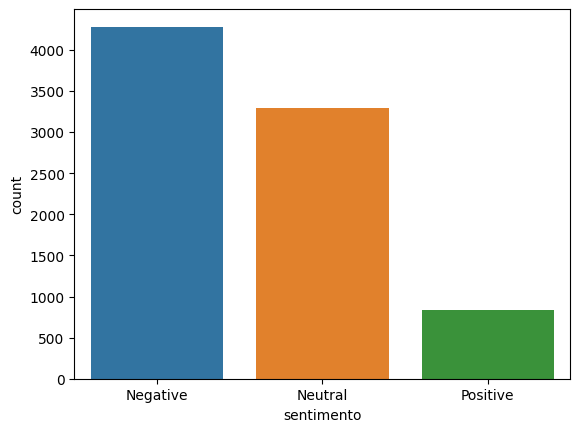

In [57]:
sns.countplot(x = lula_model['sentimento'])

### 6.1.2 Taxas de aprovação e rejeição: Lula

In [58]:
calcula_taxas(lula_model)

Taxa de aprovação do candidato: 10.0%
Taxa de rejeição do candidato: 50.9%


### 6.2 Ciro Gomes

In [59]:
ciro_sentimentos = analisa_sentimentos(replies_ciro, apoio_ciro, negacao_ciro)
ciro_model = pd.DataFrame.from_records(ciro_sentimentos)
# retira respostas feitas apenas com links
ciro_model = ciro_model[ciro_model.texto_tratado != ' http'].reset_index().drop(columns='index')
ciro_model.head()

### 6.2.1 Visualização da análise de sentimentos para Ciro

In [ ]:
sns.countplot(x = ciro_model['sentimento'])

### 6.2.2 Taxas de aprovação e rejeição: Ciro Gomes

In [ ]:
calcula_taxas(ciro_model)

### 6.3 Bolsonaro

In [ ]:
bolsonaro_sentimentos = analisa_sentimentos(replies_bolsonaro, apoio_bolsonaro, negacao_bolsonaro)
bolsonaro_model = pd.DataFrame.from_records(bolsonaro_sentimentos)
# retira respostas feitas apenas com links
bolsonaro_model = bolsonaro_model[bolsonaro_model.texto_tratado != ' http'].reset_index().drop(columns='index')
bolsonaro_model.head()

### 6.3.1 Visualização da análise de sentimentos para Bolsonaro

In [ ]:
sns.countplot(x = bolsonaro_model['sentimento'])

### 6.3.2 Taxas de aprovação e rejeição: Bolsonaro

In [ ]:
calcula_taxas(bolsonaro_model)

### 7. Conclusão da Análise de Sentimentos

A interpretação de texto não é uma tarefa trivial para humanos, assim como não é para algoritmos de PLN. Sendo assim, não é uma tarefa simples classificar tweets em positivos ou negativos, pois estamos lidando com vícios de linguagem, sarcasmo, ironias, diferentes interpretações e, neste caso, um contexto socio-político muito forte da situação brasileira da última década.

Considerando os resultados que extraímos, é possível notar a forte rejeição a todos os candidatos que apresentamos. Reflexo dos acontecimentos dos últimos anos que corroboram com a imagem de desconfiança para com políticos.

Dentro os 3 presidenciáveis, **Ciro Gomes possui a maior taxa de aprovação** e a **menor taxa de rejeição**, mas isso não necessariamente reflete os resultados das eleições, pois Ciro possui o menor número de eleitores entre os três candidatos. Apenas enfatiza que dentro desta bolha social (Twitter), os usuários que interagem com seus posts o fazem mais positivamente do que os usuários dos demais políticos.


### 8. Possíveis melhorias na Análise de Sentimentos

**Tratamento para falsos positivos**

Ao responder o tweet de um candidato, é comum que os eleitores afirmem apoio a outro presidenciável. Nesses casos, a classificação de sentimento daquela resposta em si pode ser positiva para o candidato que ele apoia, mas negativa para o dono do tweet.

Sendo assim, optamos por inverter o sentimento. O tratamento fica nítido no caso abaixo, em que o usuário responde ao Ciro Gomes:

In [ ]:
sentiment_task("Lula vai trazer amor e paz e todos vão amanhecer felizes por voltarem a sonhar")

É claramente um sentimento positivo, mas direcionado ao Lula. Como se trata de outro candidato, a classificação se tornaria negativa através de um possível tratamento.